In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

data = pd.read_excel('C:/Users/凡/Desktop/project/durham_mds/data/PDNTBA pKa scans.xls',
                    sheet_name="pdntba20mmscan2")

In [3]:
def edit_df(df, i, j):
    """
    function to drop empty cells and separate the type of additive compound and its volume.
    df: pd.DataFrame
        headers include information about the amount of HCl,
        the first row has wavelength and absorbance like header row,
        other cells have numerical values,
        there are some unnecessary & missing values as well.
    i: int, start column
    j: int, end column
    """
    # Remove null values of each HCl column.
    temp = df.iloc[1:, i:j].dropna()
    
    # Take the information about the additive & the amount of it from the header.
    cols = temp.columns
    add = (cols[0]).split(' ')
    if add[-1] != "hcl":
        additive = 'hcl'
        vol = 0
    else:
        additive = add[-1]
        vol = eval(add[0])
    temp = temp.rename(columns = {cols[0] : "wavelength",
                                 cols[1] : "absorbance"})
    temp['additive'] = additive
    temp['volume(mm)'] = vol
    return temp


def data_transformer(df):
    """
    function to transform the shape of dataframe.
    df: pd.DataFrame
    """
    # Remove unnecessary cells by detercting an empty row.
    df = df.dropna(axis = 1,
                  how = "all")
    idx = df.index[data.isnull().all(axis=1)].tolist()
    if len(idx) > 0:
        df = df.iloc[:idx[0], :]

    # Create the transformed data frame.
    transformed_df = pd.DataFrame()
    iter = int(len(df.columns) // 2)
    for i in range(iter):
        temp = edit_df(df, (2 * i), (2 * i + 2))
        transformed_df = pd.concat([transformed_df, temp])

    return transformed_df.reset_index(drop = True)
    
    
df = data_transformer(data)

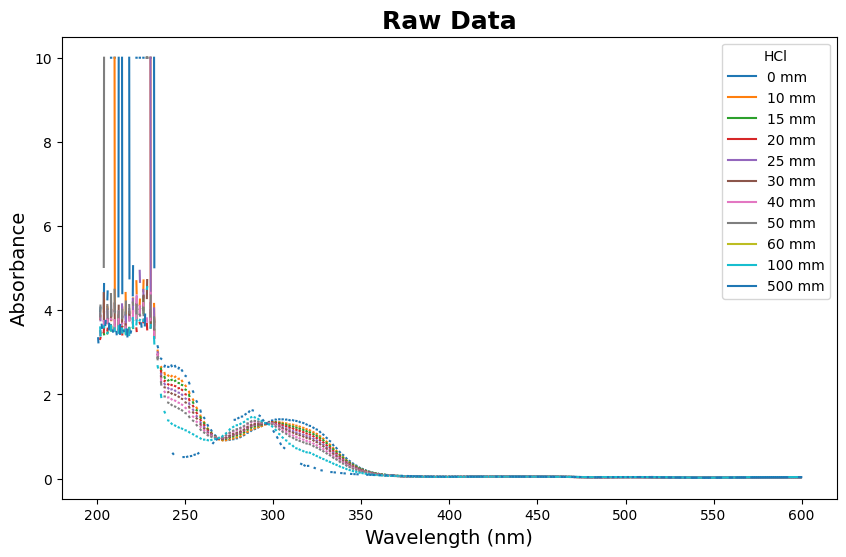

In [16]:
def pivot_n_check_the_plot(df, plot_title, pivot = True):
    """
    Function to pivot the dataframe and plot the graph.
    df: pd.DataFrame, must have 3 variables of wavelength, input volume of HCl, and absorbance
    plot_title: str, the title of the plot.
    pivot: Boolean, pivot the table with columns of wavelength and values of absorbance if True
    """
    if pivot:
        df = pd.pivot_table(df,
                            columns = "wavelength",
                            index = "volume(mm)",
                            values = "absorbance")
    plt.figure(figsize = (10, 6))
    x_data = df.columns

    for i in df.index:
        y_data = df.loc[i, :]
        plt.plot(x_data, y_data, label = f"{i} mm")
    plt.xlabel("Wavelength (nm)", fontsize = 14)
    plt.ylabel("Absorbance", fontsize = 14)
    plt.title(plot_title, fontsize = 18, weight = "bold")
    plt.legend(loc = "upper right",
            title = "HCl")
    plt.show()
    return df
raw_df = df[['wavelength', 'absorbance', 'volume(mm)']].copy()
raw_pivot = pivot_n_check_the_plot(raw_df, "Raw Data")

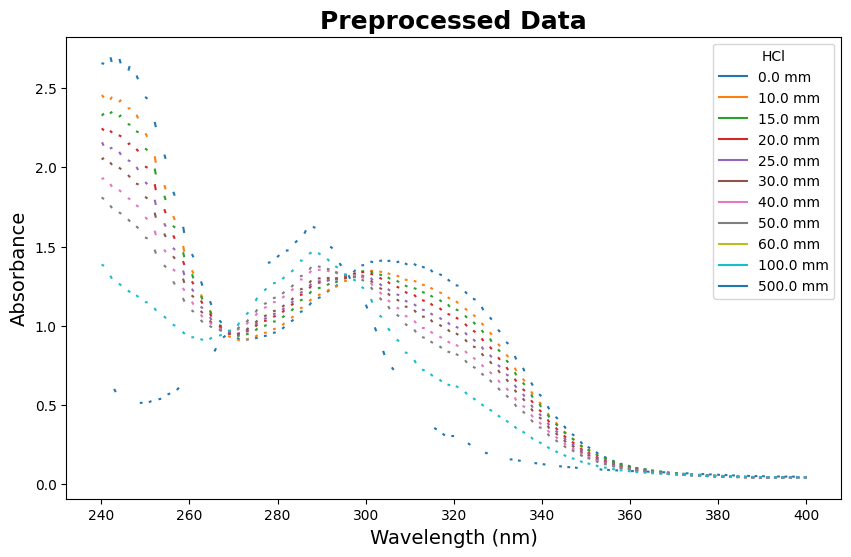

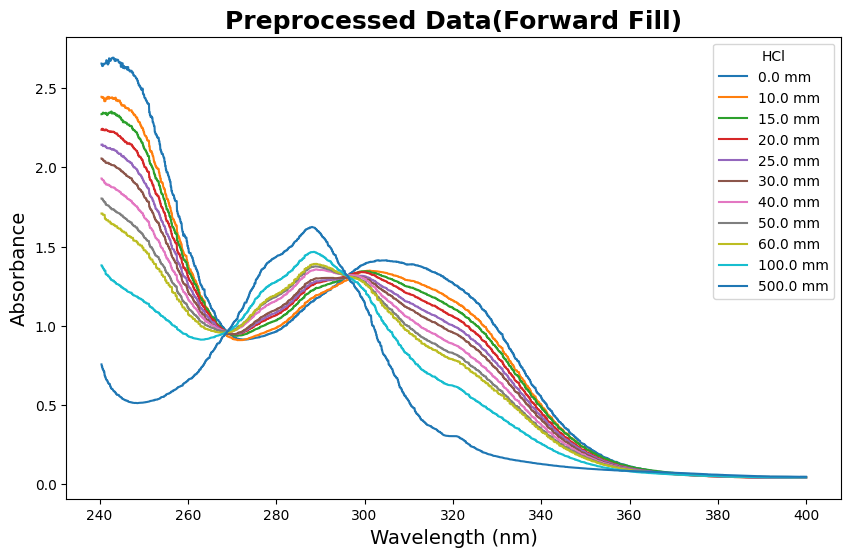

In [17]:
# Remove unnecessary range of wavelength.
df2 = raw_df[(raw_df.wavelength > 240) & (raw_df.wavelength <= 400)].copy() 
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2 = df2.interpolate(method='linear', axis=1)

# Pivot the table and check its plot.
pivot_df2 = pivot_n_check_the_plot(df2, "Preprocessed Data") 

# Fill forward method for the missing values & drop other missing values
pivot_df2 = pivot_n_check_the_plot((pivot_df2.ffill(axis = 1)).dropna(axis=1), "Preprocessed Data(Forward Fill)", pivot = False)

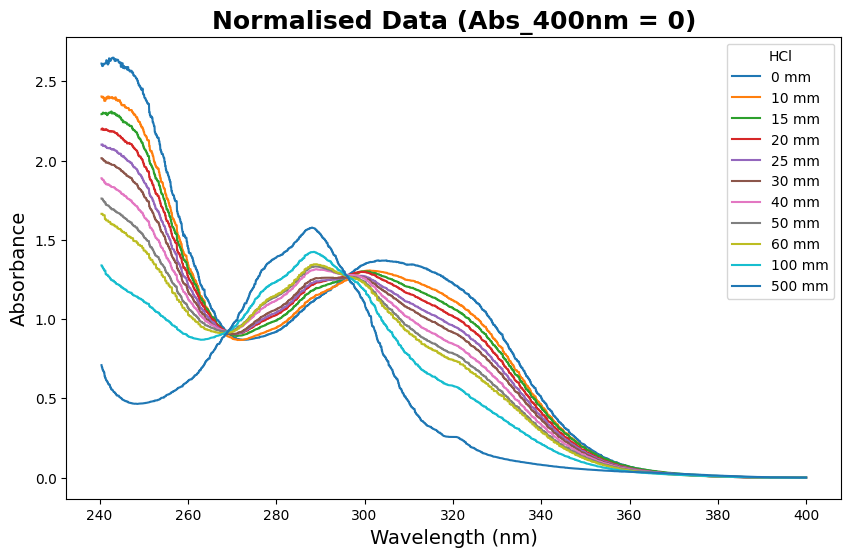

In [10]:
norm_df = pivot_df2.copy()

# Normalise all the data based on the absobance at 400nm as 0.
for hcl in norm_df.index:
    abs_400 = (norm_df.loc[hcl, :].dropna(axis = 0)).values[-1]
    norm_df.loc[hcl, :] = (norm_df.loc[hcl, :]).sub(abs_400)

# Pivot the table and check its plot.
norm_df = pivot_n_check_the_plot(norm_df, 
                                "Normalised Data (Abs_400nm = 0)",
                                pivot = False)

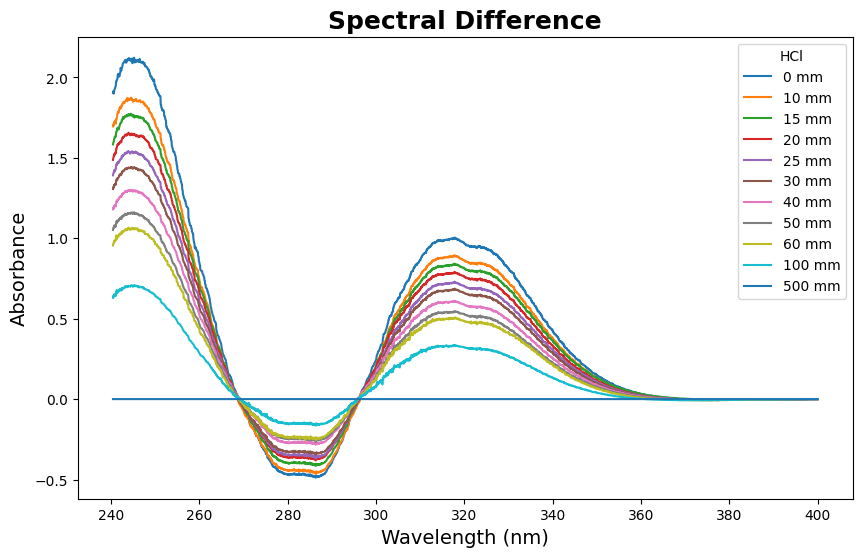

In [11]:
# The acid baseline would be at HCl == 500mm.
acid_abs = np.array(norm_df.loc[500])

spct_df = norm_df - acid_abs
spct_df = pivot_n_check_the_plot(spct_df, "Spectral Difference", pivot=False)

In [18]:
spct_data = spct_df.copy().reset_index(inplace = False)
spct_data = pd.melt(spct_data,
                   id_vars=['volume(mm)']) # Melt the dataframe to choose min/max values easily.
                   
# Maximum absorbance peak: 317.81 nm
abs_max = spct_data[(spct_data.wavelength>310) & (spct_data.wavelength < 330)].value.max()
max_idx = spct_data[(spct_data.wavelength>310) & (spct_data.wavelength < 330)].value.idxmax()
wl_max = spct_data.loc[max_idx, 'wavelength']
# Minimum absorbance peak: 286.36 nm
abs_min = spct_data[(spct_data.wavelength>270) & (spct_data.wavelength < 290)].value.min()
min_idx = spct_data[(spct_data.wavelength>270) & (spct_data.wavelength < 290)].value.idxmin()
wl_min = spct_data.loc[min_idx, 'wavelength']

317.8129883


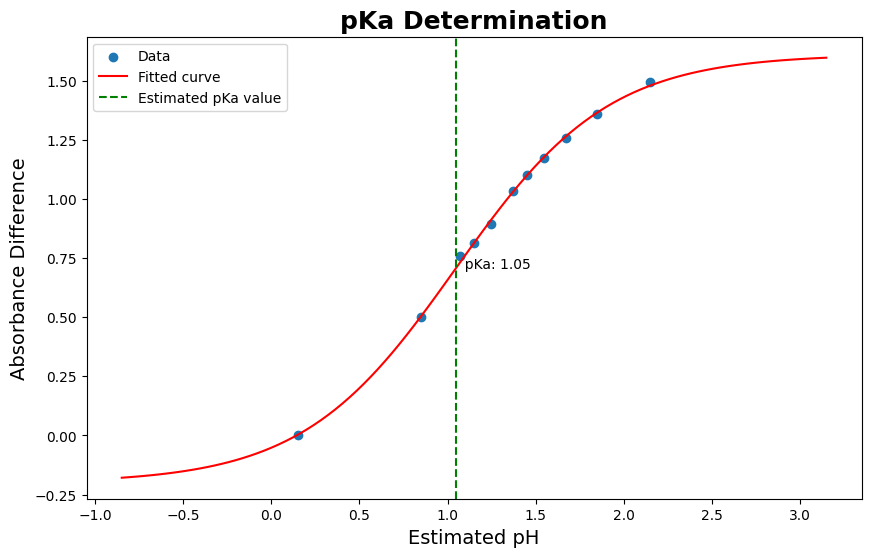

In [13]:
def HCl_to_pH(proton, initial=0.15):
    """
    A function to convert the amount of HCl to [H+].
    We can calculate brief value of pH, but this is not accurate.
    proton: float, the amount of proton, which is derived from the amount of HCl.
    initial: float, constant to fix the pH value.
    """
    if proton != 0:
        pH = -np.log10(proton)
    else:
        pH = np.float64(2.3) 
    return pH - initial


def henderson_hasselbalch(pH, pKa, A, B):
    return A / (1 + 10**(pKa - pH)) + B
    
    
y = np.array(abs(spct_df.loc[:, wl_max]) + abs(spct_df.loc[:, wl_min]), dtype=np.float64)
x = np.array(spct_df.index / 1000)
pH_data = np.array(list(map(HCl_to_pH, x)))

# Initial estimation values
p0 = [2, max(y), 0]    

# Fit the curve.
popt, pcov = curve_fit(henderson_hasselbalch,
                      pH_data,
                      y,
                      p0 = p0)
x_fit = np.linspace(min(pH_data)-1, max(pH_data)+1, 100)
y_fit = henderson_hasselbalch(x_fit, *popt)


# Check the final graph and determined pKa value.
plt.figure(figsize = (10, 6))
plt.scatter(pH_data, y, label = "Data")
plt.plot(x_fit, y_fit, label = "Fitted curve", color = "red")
plt.axvline(x = popt[0], color = "green", linestyle = "--", label = "Estimated pKa value")
plt.annotate(f"  pKa: {popt[0]:.2f}",
            xy = (popt[0], henderson_hasselbalch(popt[0], *popt)))

plt.xlabel("Estimated pH", fontsize = 14)
plt.ylabel("Absorbance Difference", fontsize = 14)
plt.title("pKa Determination", fontsize = 18, weight = "bold")
plt.legend(loc = "best")
plt.show()